In [14]:
%pylab inline
from astropy.io import fits
import glob
import pandas as pd
from pandas import DataFrame
from scipy.interpolate import interp1d
from nirspec import divspec, gluespec
from spec_utils import vgeo
import pdb as pdb
import astropy
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astroquery.hitran import Hitran
from flux_calculator import extract_hitran_data, calc_fluxes, extract_vup, make_rotation_diagram
import numpy
from slabspec import extract_hitran_data

Populating the interactive namespace from numpy and matplotlib


In [6]:
#12/13/2010 & 12/14/2010
hdulist20101213 = fits.open('/Users/hanna/Desktop/URSI/Summer_Research/ABAUR_20101213_glue.fits')
data20101213 = hdulist20101213[1].data
#12/31/2012
hdulist20121231 = fits.open('/Users/hanna/Desktop/URSI/Summer_Research/ABAUR_20121231_glue.fits')
data20121231 = hdulist20121231[1].data
#01/01/2013 & 01/03/2013
hdulist20130101 = fits.open('/Users/hanna/Desktop/URSI/Summer_Research/ABAUR_20130101_glue.fits')
data20130101 = hdulist20130101[1].data
#12/23/2013 & 12/24/2013
hdulist20131223 = fits.open('/Users/hanna/Desktop/URSI/Summer_Research/ABAUR_20131223_glue.fits')
data20131223 = hdulist20131223[1].data

In [7]:
#Telluric Cutoff
no = 0.60
from astropy.table import Table
t = Table.read('/Users/hanna/Desktop/URSI/Summer_Research/ABAUR_20101213_glue.fits')
df1213 = t.to_pandas()
df1213 = DataFrame(df1213, columns = ['wave', 'div', 'src', 'std'])
df1213.loc[df1213['std'] >0, 'std'] = (df1213['std']/1.302589514146253) #normalize
df1213.loc[df1213['std'] <no, 'div'] = None

t = Table.read('/Users/hanna/Desktop/URSI/Summer_Research/ABAUR_20121231_glue.fits')
df1231 = t.to_pandas()
df1231 = DataFrame(df1231, columns = ['wave', 'div', 'src', 'std'])
df1231.loc[df1231['std'] >0, 'std'] = (df1231['std']/1.3036475482894394) #normalize
df1231.loc[df1231['std'] <no, 'div'] = None


t = Table.read('/Users/hanna/Desktop/URSI/Summer_Research/ABAUR_20130101_glue.fits')
df0101 = t.to_pandas()
df0101 = DataFrame(df0101, columns = ['wave', 'div', 'src', 'std'])
df0101.loc[df0101['std'] >0, 'std'] = (df0101['std']/1.1775503345014968) #normalize
df0101.loc[df0101['std'] <no, 'div'] = None

t = Table.read('/Users/hanna/Desktop/URSI/Summer_Research/ABAUR_20131223_glue.fits')
df1223 = t.to_pandas()
df1223 = DataFrame(df1223, columns = ['wave', 'div', 'src', 'std'])
df1223.loc[df1223['std'] >0, 'std'] = (df1223['std']/1.2383725618468646) #normalize
df1223.loc[df1223['std'] <no, 'div'] = None


**Doppler Shift Equation:**
$\Delta$$\gamma$ = (v*$\gamma$)/c

In [8]:
#Doppler Shift
c = 3*10**5 #km/s

mydate1213=Time('2010-12-13T00:00:00.0', format='isot', scale='utc')
mycoord1213=SkyCoord('4h55m45.85s', '+30d34m02.7s', frame='icrs')
mydate1231=Time('2012-12-31T00:00:00.0', format='isot', scale='utc')
mycoord1231=SkyCoord('4h56m34.65s', '+30d34m08.3s', frame='icrs')
mydate0101=Time('2013-01-23T00:00:00.0', format='isot', scale='utc')
mycoord0101=SkyCoord('5h56m34.66s', '+30d34m08.3s', frame='icrs')
mycoord1223=SkyCoord('4h56m38.77s', '+30d34m12.0s', frame='icrs')
mydate1223=Time('2013-12-23T00:00:00.0', format='isot', scale='utc')

#Calculate the heliocentric velocity (Earth-induced + intrinsic)
myv1213=vgeo(mydate1213, mycoord1213, vhel=-7.93)
myv1231=vgeo(mydate1231, mycoord1231, vhel=-7.93)
myv0101=vgeo(mydate0101, mycoord0101, vhel=-7.93)
myv1223=vgeo(mydate1223, mycoord1223, vhel=-7.93)

#print(myv, ' km/s')
gamma1213 = 4.711
gamma1231 = 4.711 #the wavelength changes between 12/31/2012 and 01/01/2013 have to go in and fix glue [RESOLVED]
gamma0101 = 4.647
gamma1223 = 4.647

delta_gamma1213 = (myv1213*gamma1213)/c
delta_gamma1231 = (myv1231*gamma1231)/c
delta_gamma0101 = (myv0101*gamma0101)/c
delta_gamma1223 = (myv1223*gamma1223)/c

df1213.loc[df1213['wave']> 0, 'wave'] = (df1213['wave']+delta_gamma1213)
df1231.loc[df1231['wave']> 0, 'wave'] = (df1231['wave']+delta_gamma1231)
df0101.loc[df0101['wave']> 0, 'wave'] = (df0101['wave']+delta_gamma0101)
df1223.loc[df1223['wave']> 0, 'wave'] = (df1223['wave']+delta_gamma1223)

C:\Users\hanna\Anaconda\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


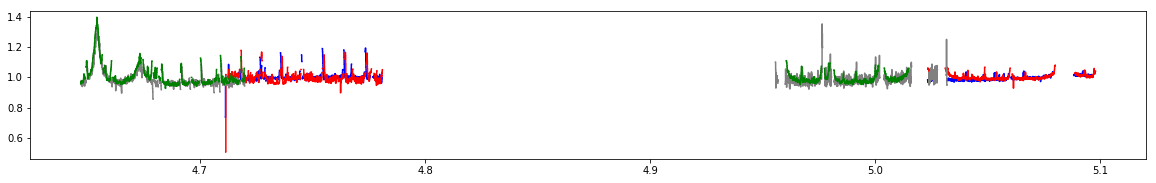

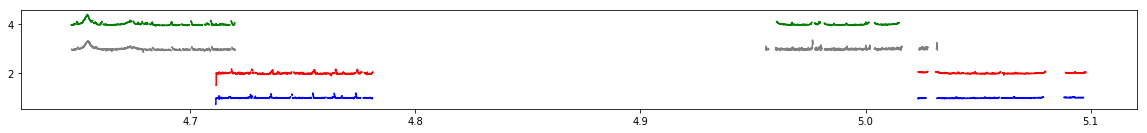

In [9]:
#Full Spectrum
fig =plt.figure(figsize(20,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

plt.plot()
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df0101['wave'],df0101['div'],linestyle='steps-mid', color = 'grey')
ax4.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')

fig = plt.figure(figsize(20,4))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

ax1.plot(df1213['wave'],df1213['div']+0,linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div']+1,linestyle='steps-mid', color = 'red')
ax3.plot(df0101['wave'],df0101['div']+2,linestyle='steps-mid', color = 'grey')
ax4.plot(df1223['wave'],df1223['div']+3,linestyle='steps-mid', color = 'green')




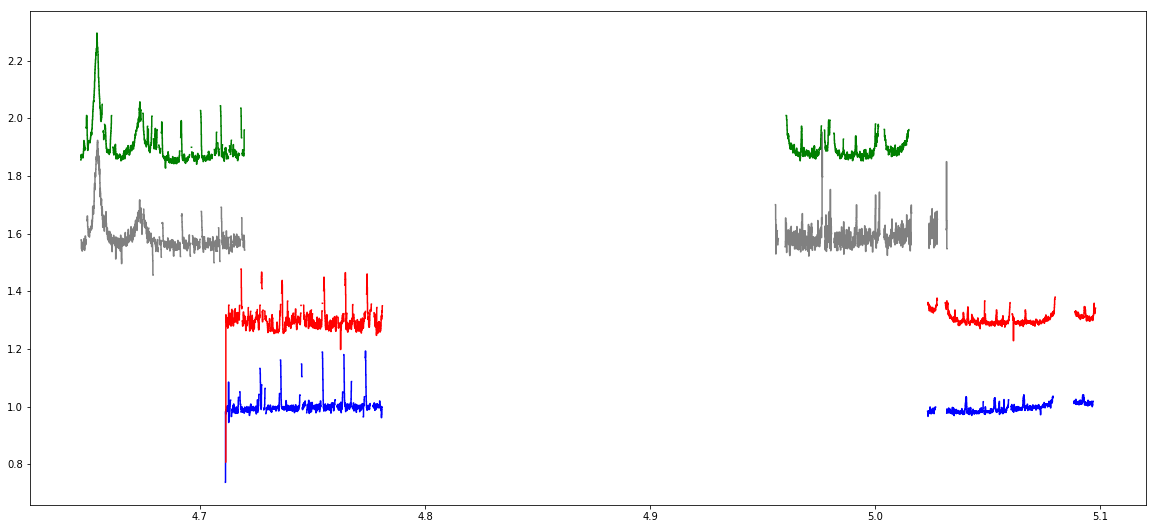

In [17]:
fig =plt.figure(figsize(20,20))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

plt.plot()
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div']+0.3,linestyle='steps-mid', color = 'red')
ax3.plot(df0101['wave'],df0101['div']+0.6,linestyle='steps-mid', color = 'grey')
ax4.plot(df1223['wave'],df1223['div']+0.9,linestyle='steps-mid', color = 'green')

In [ ]:
low1 = 4.717
high1 = 4.719

low2 = 4.70
high2 = 4.701

low3 = 4.708
high3 = 4.71

low4 = 4.713
high4 = 4.715

low5 = 4.725
high5 = 4.730

fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

plt.xlim([low1,high1])
plt.ylim([0.6,1.5])

plt.plot()
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df0101['wave'],df0101['div'],linestyle='steps-mid', color = 'grey')
ax4.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')


fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

plt.xlim([low1, high1])
plt.ylim([0.5,6])

ax1.plot(df1213['wave'],df1213['div']+0,linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div']+1,linestyle='steps-mid', color = 'red')
ax3.plot(df0101['wave'],df0101['div']+2,linestyle='steps-mid', color = 'grey')
ax4.plot(df1223['wave'],df1223['div']+3,linestyle='steps-mid', color = 'green')


In [ ]:
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

plt.xlim([low2, high2])
plt.ylim([0.5,1.5])

ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df0101['wave'],df0101['div'],linestyle='steps-mid', color = 'grey')
ax4.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')

fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

plt.xlim([low2, high2])
plt.ylim([0.5,6])

ax1.plot(df1213['wave'],df1213['div']+0,linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div']+1,linestyle='steps-mid', color = 'red')
ax3.plot(df0101['wave'],df0101['div']+2,linestyle='steps-mid', color = 'grey')
ax4.plot(df1223['wave'],df1223['div']+3,linestyle='steps-mid', color = 'green')


In [ ]:
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

plt.xlim([low3, high3])
plt.ylim([0.5,1.5])

ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df0101['wave'],df0101['div'],linestyle='steps-mid', color = 'grey')
ax4.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')

fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

plt.xlim([low3, high3])
plt.ylim([0.5,6])

ax1.plot(df1213['wave'],df1213['div']+0,linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div']+1,linestyle='steps-mid', color = 'red')
ax3.plot(df0101['wave'],df0101['div']+2,linestyle='steps-mid', color = 'grey')
ax4.plot(df1223['wave'],df1223['div']+3,linestyle='steps-mid', color = 'green')


In [ ]:
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

plt.xlim([low4, high4])
plt.ylim([0.5,1.5])

ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df0101['wave'],df0101['div'],linestyle='steps-mid', color = 'grey')
ax4.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')

fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

plt.xlim([low4, high4])
plt.ylim([0.5,6])

ax1.plot(df1213['wave'],df1213['div']+0,linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div']+1,linestyle='steps-mid', color = 'red')
ax3.plot(df0101['wave'],df0101['div']+2,linestyle='steps-mid', color = 'grey')
ax4.plot(df1223['wave'],df1223['div']+3,linestyle='steps-mid', color = 'green')

**Line Profiles**

In [ ]:
#Read in HITRAN data
out_all=extract_hitran_data('CO',4.6,5.2)  #astropy table
lineflux_data=extract_vup(out_all,1)

#For Data2010121314
wave=df1213['wave']
flux=df1213['div']
out=calc_fluxes(wave,flux,lineflux_data,fwhm_v=17., sep_v=80., cont=1.12,vet_fits=False, plot=True, v_dop=15.)

rot1213=make_rotation_diagram(out)

In [ ]:
#Read in HITRAN data
out_all=extract_hitran_data('CO',4.6,5.2)  #astropy table
lineflux_data=extract_vup(out_all,1)

#For Data201212310103
wave=df1231['wave']
flux=df1231['div']
out=calc_fluxes(wave,flux,lineflux_data,fwhm_v=17., sep_v=80., cont=1.12,vet_fits=False, plot=True, v_dop=15.)

rot1231=make_rotation_diagram(out)

In [ ]:
#Read in HITRAN data
out_all=extract_hitran_data('CO',4.6,5.2)  #astropy table
lineflux_data=extract_vup(out_all,1)

#For Data2013010103
wave=df0101['wave']
flux=df0101['div']
out=calc_fluxes(wave,flux,lineflux_data,fwhm_v=17., sep_v=80., cont=1.12,vet_fits=False, plot=True, v_dop=15.)

rot0101=make_rotation_diagram(out)

In [ ]:
#Read in HITRAN data
out_all=extract_hitran_data('CO',4.6,5.2)  #astropy table
lineflux_data=extract_vup(out_all,1)

#For Data2013122324
wave=df1223['wave']
flux=df1223['div']
out=calc_fluxes(wave,flux,lineflux_data,fwhm_v=17., sep_v=80., cont=1.12,vet_fits=False, plot=True, v_dop=15.)

rot1223=make_rotation_diagram(out)

**Rotation Diagram**

F = A*$\sigma$*$\sqrt{2\pi}$*$\frac{c}{\lambda^2}$      Just use flux calc - how to fix for data['flux']

In [ ]:
fig =plt.figure(figsize(8,15))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)


plt.plot()
plt.ylim([-55,-51])
ax1.plot(rot1213['x'],rot1213['y'],'bo')
ax2.plot(rot1231['x'],rot1231['y'],'ro')
ax3.plot(rot0101['x'],rot0101['y'],'o')
ax4.plot(rot1223['x'],rot1223['y'],'o')